# Anomaly Detection: From Decision Tree to Generative Model 
**Author**: Jeremy Vachier\
**Date**: 2024

Anamaly detection plays an important role in predictive maintenance. Often anomalies are particularly difficult to identify. In this notebook, different models are compared
1) Isolation Forest
2) AutoEncoders: \
    a- Deep Neural Network \
    b- Recurrent Neural Network (LSTM)
3) Variational AutoEncoder: Recurrent Neural Network (LSTM)

Also available on my Kaggle profile: \
https://www.kaggle.com/jvachier/anomaly-detection

In [148]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler

import keras
import tensorflow as tf 
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model 
from tensorflow.keras.optimizers.legacy import Adam

# CPU & GPU

In [149]:
devices = tf.config.list_logical_devices()
print(devices)
gpus = tf.config.list_physical_devices('GPU')
details = tf.config.experimental.get_device_details(gpus[0])
print("GPU details: ", details)
tf.config.set_soft_device_placement(True)

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


# Loading Data

In [150]:
sensor_Data = pd.read_csv('./data/PdM_telemetry.csv')
failure = pd.read_csv('./data/PdM_failures.csv')

# Data Processing

In [151]:
sensor_Data['datetime'] = pd.to_datetime(sensor_Data["datetime"])
failure['datetime'] = pd.to_datetime(failure["datetime"])

sensor_Data.rename(columns={"datetime": "time"},inplace=True)
failure.rename(columns={"datetime": "time"},inplace=True)

failure.loc[failure["failure"] != 0, "failure"] = 1
failure["failure"] = failure["failure"].astype("int64")

sensor_Data.set_index('time',inplace=True)
failure.set_index('time',inplace=True)

# Select a Machine

In [152]:
machine_name = 10

In [153]:
sensor_Data = sensor_Data.query("machineID == @machine_name")
failure = failure.query("machineID == @machine_name")

# Different Models

1) Isolation Forest
2) AutoEncoders: \
    a- Deep Neural Network \
    b- Recurrent Neural Network (LSTM)
3) Variational AutoEncoder: Recurrent Neural Network (LSTM)

## 1) Isolation Forest

In [154]:
sensor_Data_machine = sensor_Data.copy()
sensor_Data_machine.drop(columns='machineID', inplace=True)

In [155]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(sensor_Data_machine.values)#.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [157]:
model_time_series_t =  IsolationForest()
model_time_series_t.fit(data.values)

sensor_Data_machine['anomaly'] = model_time_series_t.predict(data.values)

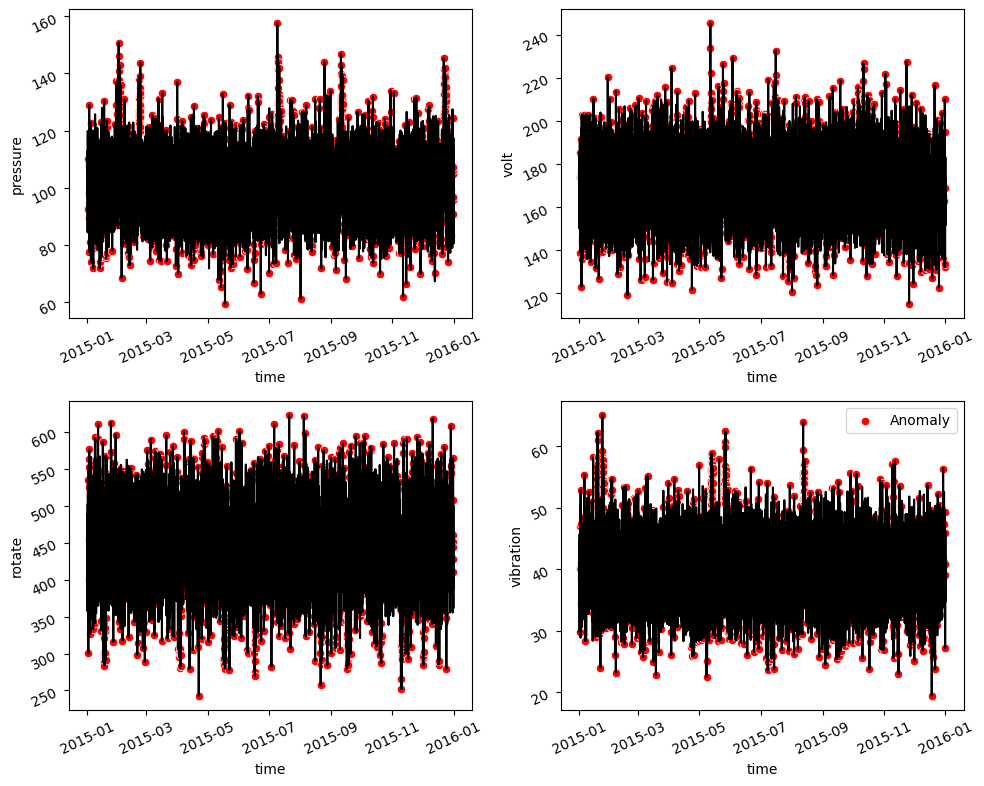

In [158]:
volt = sensor_Data.loc[sensor_Data_machine['anomaly'] == -1, ['volt']] #anomaly
pressure = sensor_Data.loc[sensor_Data_machine['anomaly'] == -1, ['pressure']] #anomaly
vibration = sensor_Data.loc[sensor_Data_machine['anomaly'] == -1, ['vibration']] #anomaly
rotate = sensor_Data.loc[sensor_Data_machine['anomaly'] == -1, ['rotate']] #anomaly


# create the time series subplots 
fig,ax =  plt.subplots( 2, 2, 
                       figsize = ( 10, 8)) 
  
sns.lineplot( x = sensor_Data_machine.index, y = "pressure",  
             color = 'k', data = sensor_Data_machine,  
             ax = ax[0][0]) 
sns.scatterplot(x = pressure.index, y = 'pressure',
                color='r', data = pressure, 
                ax = ax[0][0]) 

ax[0][0].tick_params(labelrotation = 25) 
sns.lineplot( x = sensor_Data_machine.index, y = "volt",  
             color = 'k', data = sensor_Data_machine, 
             ax = ax[0][1]) 
sns.scatterplot(x = volt.index, y = 'volt',
                color='r', data = volt, 
                ax = ax[0][1])
  
ax[0][1].tick_params(labelrotation = 25) 
sns.lineplot(x = sensor_Data_machine.index, y = "rotate",  
             color = 'k', data = sensor_Data_machine, 
             ax = ax[1][0]) 
sns.scatterplot(x = rotate.index, y = 'rotate',
                color='r', data = rotate, 
                ax = ax[1][0])


ax[1][0].tick_params(labelrotation = 25)   
sns.lineplot(x = sensor_Data_machine.index, y = "vibration",  
             color = 'k', data = sensor_Data_machine,
             ax = ax[1][1]) 
sns.scatterplot(x = vibration.index, y = 'vibration',
                color='r', data = vibration, label = 'Anomaly',
                ax = ax[1][1])


ax[1][1].tick_params(labelrotation = 25) 
fig.tight_layout(pad = 1.2) 

## Functions for AutoEncoder

In [159]:
time_step = 50
def create_sequences(values: list) -> np.array:
    output = []
    for i in range(len(values) - time_step + 1):
        output.append(values[i : (i + time_step)])
    return np.stack(output)

In [160]:
def result_autocendoer(model: object, x_train: np.array) -> tf.Tensor:
    # Calculate the reconstruction error for each data point
    reconstructions_deep = model.predict(x_train)
    print(x_train.shape,reconstructions_deep.shape)
    mse = tf.reduce_mean(tf.square(x_train - reconstructions_deep), axis=[1, 2])
    return mse

## 2) AutoEncoders
### a- Deep Neural Network

In [161]:
sensor_Data_machine = sensor_Data.copy()
sensor_Data_machine.drop(columns='machineID', inplace=True)

In [162]:
scaler_auto = StandardScaler() 
np_scaled = scaler_auto.fit_transform(sensor_Data_machine)
x_train = create_sequences(np_scaled)

In [163]:
with tf.device('/device:CPU:0'):   
    input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))
    encoded = Dense(128, activation="relu")(input_layer)
    encoded = Dense(64, activation="relu")(encoded)
    encoded = Dense(32, activation="relu")(encoded)

    decoded = Dense(64, activation="relu")(encoded)
    decoded = Dense(128, activation="relu")(decoded)
    decoded = Dense(x_train.shape[2], activation="relu")(decoded)

    # Compile and fit the model
    autoencoder_deep = Model(input_layer, decoded)
    autoencoder_deep.summary()
    autoencoder_deep.compile(
        optimizer=Adam(learning_rate=0.00001), loss="mse", metrics=["accuracy"]
    )
    autoencoder_deep.fit(
        x_train, x_train, epochs=10, batch_size=128, validation_split=0.1
    )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 4)]           0         
                                                                 
 dense_12 (Dense)            (None, 50, 128)           640       
                                                                 
 dense_13 (Dense)            (None, 50, 64)            8256      
                                                                 
 dense_14 (Dense)            (None, 50, 32)            2080      
                                                                 
 dense_15 (Dense)            (None, 50, 64)            2112      
                                                                 
 dense_16 (Dense)            (None, 50, 128)           8320      
                                                                 
 dense_17 (Dense)            (None, 50, 4)             516 

In [164]:
mse = result_autocendoer(autoencoder_deep, x_train)

273/273 [==============================] - 2s 7ms/step
(8712, 50, 4) (8712, 50, 4)


In [165]:
anomaly_deep_scores = pd.Series(mse.numpy(), name="anomaly_scores")
anomaly_deep_scores.index = sensor_Data_machine[(time_step - 1) :].index
anomaly_deep_scores = pd.Series(mse.numpy(), name="anomaly_scores")
anomaly_deep_scores.index = sensor_Data_machine[(time_step - 1) :].index

In [166]:
threshold_deep = anomaly_deep_scores.quantile(0.98)
anomalous_deep = anomaly_deep_scores > threshold_deep

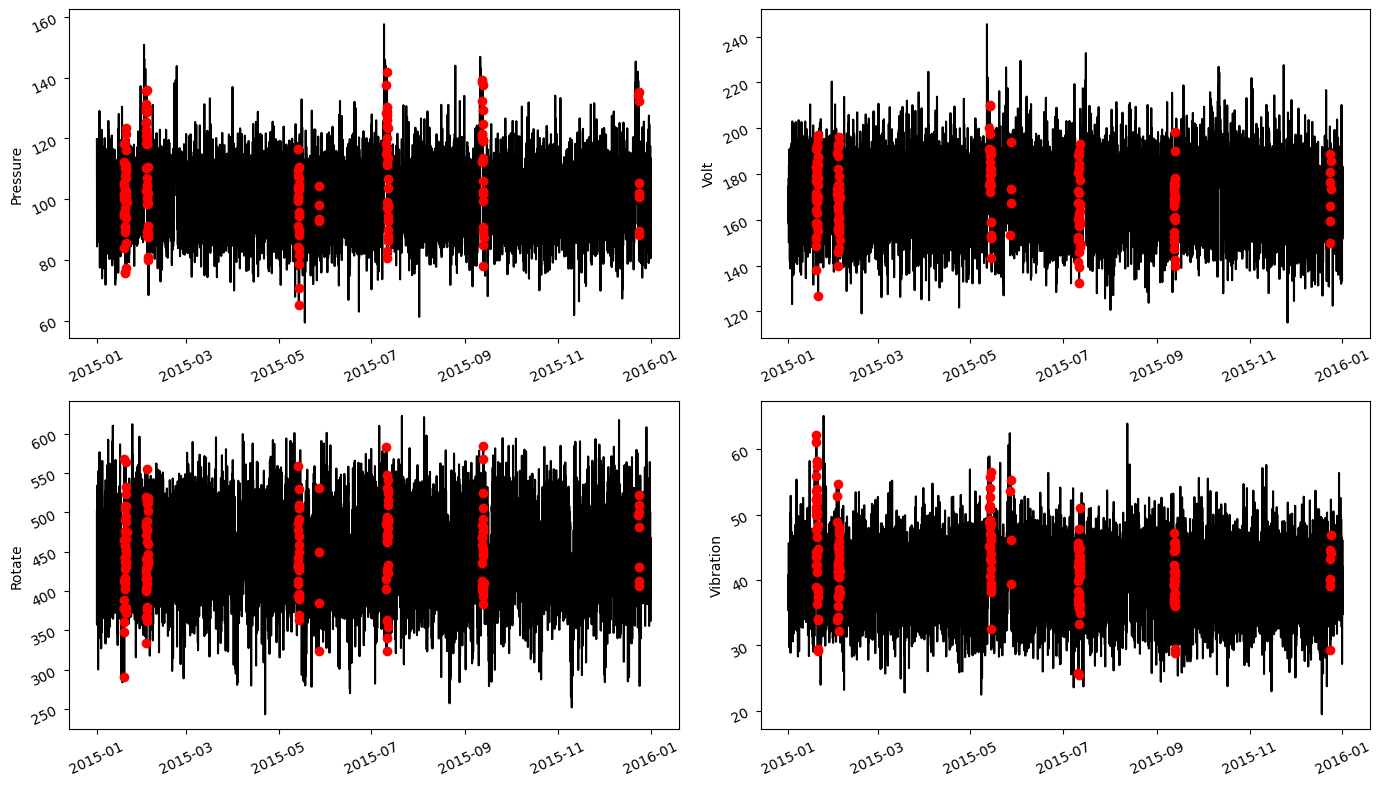

In [167]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs[0, 0].plot(
    sensor_Data_machine.index,
    sensor_Data_machine[['pressure']],
    "k",
)
axs[0, 0].plot(
    sensor_Data_machine.index[(time_step - 1) :][anomalous_deep],
    sensor_Data_machine[['pressure']][(time_step - 1) :][anomalous_deep],
    "ro",
)
axs[0, 0].set_ylabel("Pressure")
axs[0, 0].tick_params(labelrotation = 25) 

axs[1, 0].plot(
    sensor_Data_machine.index,
    sensor_Data_machine[['rotate']],
    "k",
)
axs[1, 0].plot(
    sensor_Data_machine.index[(time_step - 1) :][anomalous_deep],
    sensor_Data_machine[['rotate']][(time_step - 1) :][anomalous_deep],
    "ro",
)
axs[1, 0].set_ylabel("Rotate")
axs[1, 0].tick_params(labelrotation = 25) 

axs[0, 1].plot(
    sensor_Data_machine.index,
    sensor_Data_machine[['volt']],
    "k",
)
axs[0, 1].plot(
    sensor_Data_machine.index[(time_step - 1) :][anomalous_deep],
    sensor_Data_machine[['volt']][(time_step - 1) :][anomalous_deep],
    "ro",
)

axs[0, 1].set_ylabel("Volt")
axs[0, 1].tick_params(labelrotation = 25) 

axs[1, 1].plot(
    sensor_Data_machine.index,
    sensor_Data_machine[['vibration']],
    "k",
)
axs[1, 1].plot(
    sensor_Data_machine.index[(time_step - 1) :][anomalous_deep],
    sensor_Data_machine[['vibration']][(time_step - 1) :][anomalous_deep],
    "ro",
)
axs[1, 1].set_ylabel("Vibration")
axs[1, 1].tick_params(labelrotation = 25) 
fig.tight_layout(pad = 1.2) 

### b- Recurrent Neural Network (LSTM)

In [89]:
scaler_auto_lstm = StandardScaler() 
np_scaled = scaler_auto_lstm.fit_transform(sensor_Data[['pressure']])
x_train = create_sequences(np_scaled)

In [90]:
with tf.device('/device:GPU:0'):
    input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))
    encoded = LSTM(128, return_sequences=True)(input_layer)
    encoded_1 = LSTM(64, return_sequences=True)(encoded)
    encoded_2 = LSTM(32, return_sequences=True)(encoded_1)
    
    
    decoded = LSTM(32, return_sequences=True)(encoded_2)
    decoded_1 = LSTM(64, return_sequences=True)(decoded)
    decoded_2 = LSTM(128, return_sequences=True)(decoded_1)
    decoded_4 = TimeDistributed(Dense(x_train.shape[2], activation="relu"))(decoded_2)

    autoencoder_lstm = Model(input_layer, decoded_4)
    
    autoencoder_lstm.summary()
    autoencoder_lstm.compile(
    optimizer=Adam(
        learning_rate=0.00001), loss="mse", metrics=["accuracy"]
    )
    autoencoder_lstm.fit(
        x_train, x_train, epochs=10, batch_size=128, validation_split=0.1
    )

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_24 (LSTM)              (None, 50, 128)           66560     
                                                                 
 lstm_25 (LSTM)              (None, 50, 64)            49408     
                                                                 
 lstm_26 (LSTM)              (None, 50, 32)            12416     
                                                                 
 lstm_27 (LSTM)              (None, 50, 32)            8320      
                                                                 
 lstm_28 (LSTM)              (None, 50, 64)            24832     
                                                                 
 lstm_29 (LSTM)              (None, 50, 128)           9881

In [91]:
mse = result_autocendoer(autoencoder_lstm, x_train)

273/273 [==============================] - 5s 12ms/step
(8712, 50, 1) (8712, 50, 1)


In [92]:
anomaly_lstm_scores = pd.Series(mse.numpy(), name="anomaly_scores")
anomaly_lstm_scores.index = sensor_Data[(time_step - 1) :].index
anomaly_lstm_scores = pd.Series(mse.numpy(), name="anomaly_scores")
anomaly_lstm_scores.index = sensor_Data[(time_step - 1) :].index

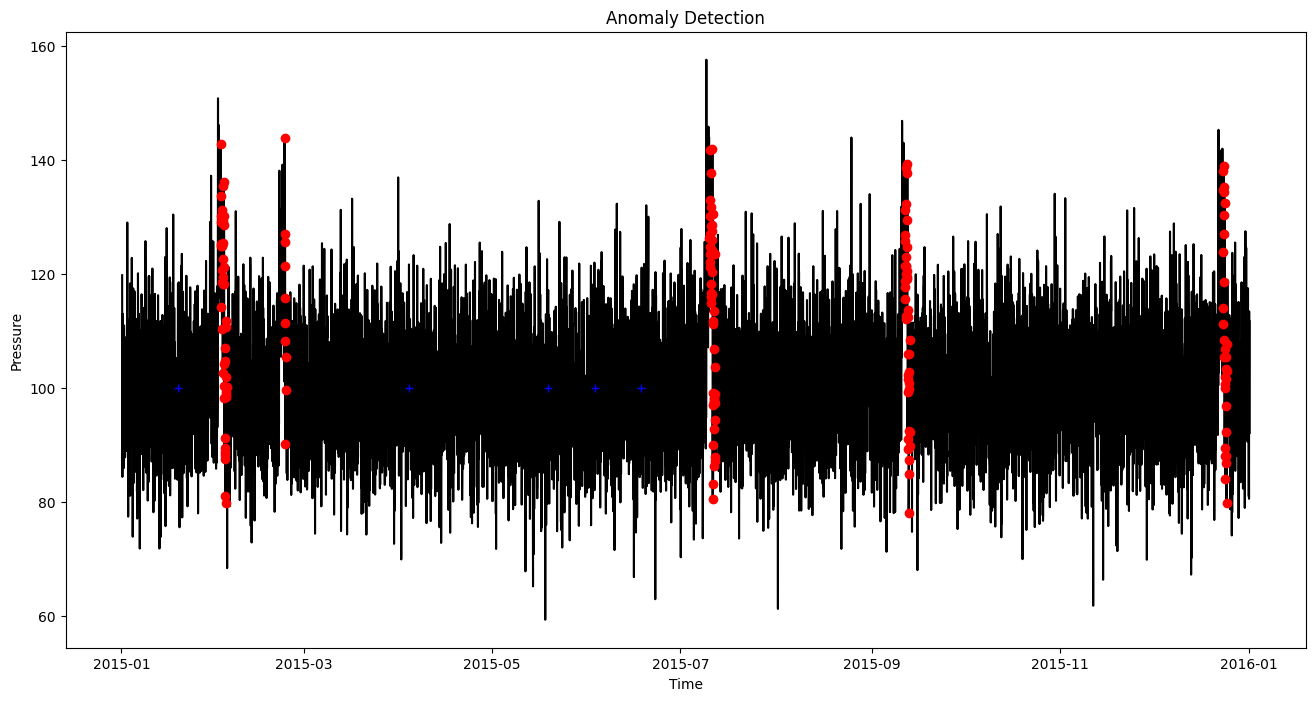

In [93]:
threshold_lstm = anomaly_lstm_scores.quantile(0.98)
anomalous_lstm = anomaly_lstm_scores > threshold_lstm

plt.figure(figsize=(16, 8))
plt.plot(
    sensor_Data.index,
    sensor_Data[['pressure']],
    "k",
)
plt.plot(
    sensor_Data.index[(time_step - 1) :][anomalous_lstm],
    sensor_Data[['pressure']][(time_step - 1) :][anomalous_lstm],
    "ro",
)
plt.plot(failure.index,failure['failure']*100,'+b')
plt.title("Anomaly Detection")
plt.xlabel("Time")
plt.ylabel('Pressure')
plt.show()

## 3) Variational AutoEncoder

In [94]:
def call(input1,input2):
    z_mean = input1
    z_log_var = input2
    batch = z_mean.shape[1]
    dim = z_mean.shape[2]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Parameters

In [95]:
scaler_auto_lstm = StandardScaler() 
np_scaled = scaler_auto_lstm.fit_transform(sensor_Data[['pressure']])
x_train = create_sequences(np_scaled)

In [96]:
latent_dim = 2

## Model

In [97]:
with tf.device('/device:GPU:0'):
    # Encoder
    input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))


    encoded = LSTM(128, return_sequences=True)(input_layer)
    encoded_1 = LSTM(64, return_sequences=True)(encoded)
    encoded_2 = LSTM(32, return_sequences=True)(encoded_1)

    z_mean = Dense(latent_dim)(encoded_2)
    z_log_var = Dense(latent_dim)(encoded_2)
    z = call(z_mean, z_log_var)

    Encoder = Model(input_layer, [z_mean, z_log_var, z], name="encoder")
    Encoder.summary()

    # Decoder
    latent_inputs = Input(shape=(x_train.shape[1],latent_dim,))

    decoded = LSTM(32, return_sequences=True)(latent_inputs)
    decoded_1 = LSTM(64, return_sequences=True)(decoded)
    decoded_2 = LSTM(128, return_sequences=True)(decoded_1)
    decoded_3 = TimeDistributed(Dense(x_train.shape[2], activation="relu"))(decoded_2)

    Decoder = Model(latent_inputs, decoded_3, name="decoder")
    Decoder.summary()

    # VAE
    outputs = Decoder(Encoder(input_layer)[2])
    vae = Model(input_layer, outputs, name='vae')
    vae.summary()

    # Loss
    reconstruction_loss = keras.losses.binary_crossentropy(input_layer, outputs) 
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    # VAE compile and fit
    vae.compile(optimizer='adam')
    vae.fit(
        x_train,x_train, epochs=10, batch_size=128, validation_split=0.1
    )

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 50, 1)]              0         []                            
                                                                                                  
 lstm_30 (LSTM)              (None, 50, 128)              66560     ['input_12[0][0]']            
                                                                                                  
 lstm_31 (LSTM)              (None, 50, 64)               49408     ['lstm_30[0][0]']             
                                                                                                  
 lstm_32 (LSTM)              (None, 50, 32)               12416     ['lstm_31[0][0]']             
                                                                                            

In [98]:
mse = result_autocendoer(vae, x_train)

273/273 [==============================] - 6s 14ms/step
(8712, 50, 1) (8712, 50, 1)


In [99]:
anomaly_vae_scores = pd.Series(mse.numpy(), name="anomaly_scores")
anomaly_vae_scores.index = sensor_Data[(time_step - 1) :].index
anomaly_vae_scores = pd.Series(mse.numpy(), name="anomaly_scores")
anomaly_vae_scores.index = sensor_Data[(time_step - 1) :].index

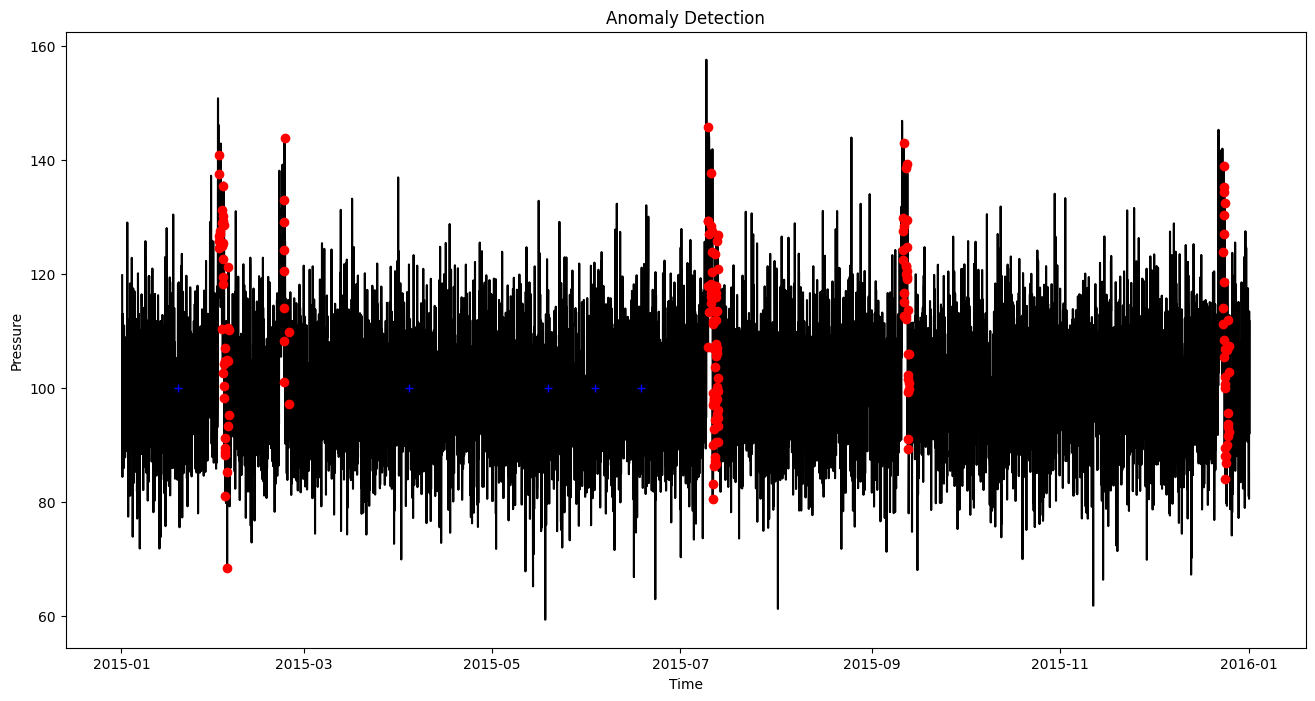

In [100]:
threshold_vae = anomaly_vae_scores.quantile(0.98)
anomalous_vae = anomaly_vae_scores > threshold_vae

plt.figure(figsize=(16, 8))
plt.plot(
    sensor_Data.index,
    sensor_Data[['pressure']],
    "k",
)
plt.plot(
    sensor_Data.index[(time_step - 1) :][anomalous_vae],
    sensor_Data[['pressure']][(time_step - 1) :][anomalous_vae],
    "ro",
)
plt.plot(failure.index,failure['failure']*100,'+b')
plt.title("Anomaly Detection")
plt.xlabel("Time")
plt.ylabel('Pressure')
plt.show()